<a href="https://colab.research.google.com/github/wai-ming-chan/fed_avg/blob/main/sanityCheck_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo program to train MNIST with Pytorch (Centralized training)

Reference: [https://meinkappa.github.io/blog/2021/09/16/MNIST-In-Pytorch.html](https://meinkappa.github.io/blog/2021/09/16/MNIST-In-Pytorch.html)

In [122]:
# import libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt


device:  cpu
Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
training data size:  60000
test data size:  10000
torch.Size([1, 28, 28])
torch.Size([28, 28])


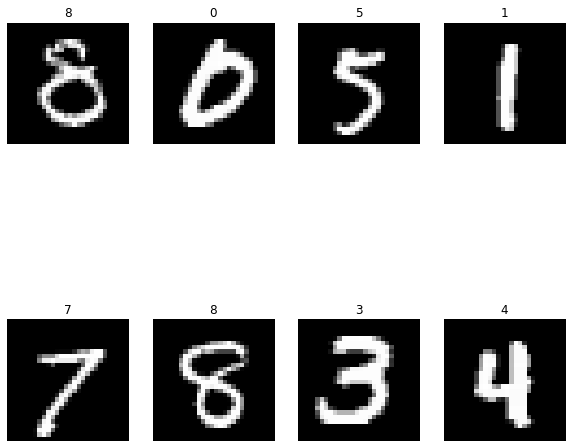

In [123]:
# grab MNIST data with torchvision datasets
## We can tell Pytorch how to manipulate the dataset by giving details.
##
### root: Where to store the data. We are storing it in data directory.
### train: Whether to grab training dataset or testing dataset. 
###         Given True value, training_data is a training dataset from MNIST. 
###         On the other hand, test_data is a testing dataset from MNIST.
### download: Whether to download if data is not already in root. We passed True to download the dataset.
### transform: What to do with data. We are converting our images of handwritten digits into Pytorch tensors so that we can train our model.

training_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

# Set GPU or CPU device. If GPU is available, we use it to speed up the training
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device: ', device)

# check the dimension of data
print(training_data)
print('training data size: ', len(training_data) )
print('test data size: ', len(test_data) )
print(training_data[0][0].shape)
print(training_data[0][0].squeeze().shape)
# plt.imshow(training_data[len(training_data)-1][0].squeeze(), cmap="gray");
# print('label: ', training_data[len(training_data)-1][1])


figure = plt.figure(figsize=(10,10))
cols, rows = 4, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [124]:
# create a dataloader. 
## A dataloader divides our data by a given batch_size and hands out each one to our model for training
## Our train_dataloader will have 64 images per batch, which makes a total of 157 batches.
train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

print(10000/64, len(test_dataloader))


156.25 157


In [125]:
# setup our model now.

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Feed our model into GPU now if there is one.
model = NeuralNetwork().to(device)
print(model)

from torchsummary import summary
help(summary)
summary(model, input_size=(1,784), batch_size=64)



NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)
Help on function summary in module torchsummary.torchsummary:

summary(model, input_size, batch_size=-1, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [64, 784]               0
            Linear-2                  [64, 512]         401,920
              ReLU-3                  [64, 512]               0
            Linear-4                   [64, 10]           5,130
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 0.89
Params size (MB): 1.55
Estimated Total Size (MB): 2.63
-

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


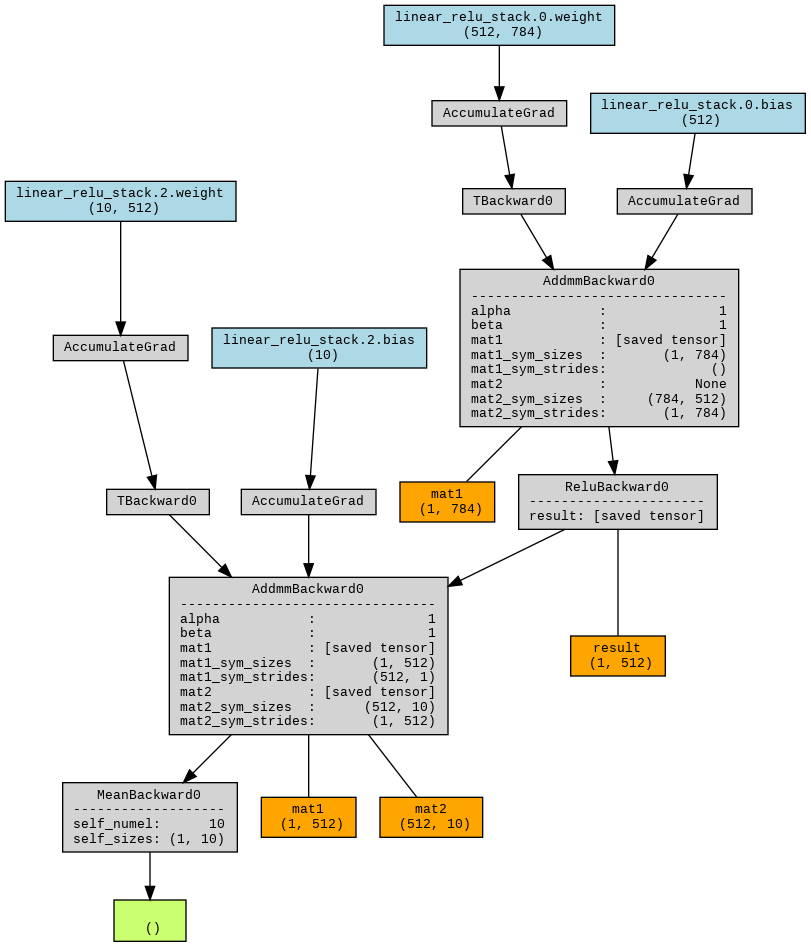

In [126]:
# Visualization of model and trace (method 1: Torchviz )
## ref: https://github.com/szagoruyko/pytorchviz
!pip install torchviz
from torchviz import make_dot

# model = nn.Sequential()
# model.add_module('W0', nn.Linear(8, 16))
# model.add_module('tanh', nn.Tanh())
# model.add_module('W1', nn.Linear(16, 1))

# x = torch.randn(1, 8)
# y = model(x)
# print('x: ', x)
# print('y: ', y)

# make_dot(y.mean(), params=dict(model.named_parameters()), show_attrs=True, show_saved=True)

model = NeuralNetwork().to(device)
sample_idx = torch.randint(len(training_data), size=(1,)).item()
img, label = training_data[sample_idx]
y = model(img)
make_dot(y.mean(), params=dict(model.named_parameters()), show_attrs=True, show_saved=True)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [64, 784]               0
            Linear-2                  [64, 512]         401,920
              ReLU-3                  [64, 512]               0
            Linear-4                   [64, 10]           5,130
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 0.89
Params size (MB): 1.55
Estimated Total Size (MB): 2.63
----------------------------------------------------------------


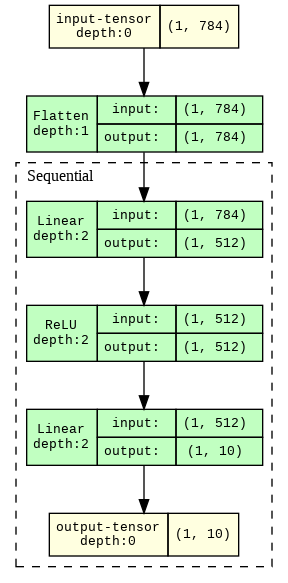

In [132]:
! pip install -q torchview
! pip install -q -U graphviz
# !pip install hiddenlayer

import torchvision

from torchview import draw_graph
from torch import nn
import torch
import graphviz

# when running on VSCode run the below command
# svg format on vscode does not give desired result
graphviz.set_jupyter_format('png')

summary(model, input_size=(1,784), batch_size=64)

model_graph = draw_graph(model, input_size=(1,784), expand_nested=True)
model_graph.visual_graph

# model = MLP()
# batch_size = 2
# # device='meta' -> no memory is consumed for visualization
# model_graph = draw_graph(model, input_size=(batch_size, 128), device='meta')
# model_graph.visual_graph

# class MLP(nn.Module):
#     """Multi Layer Perceptron with inplace option.
#     Make sure inplace=true and false has the same visual graph"""

#     def __init__(self, inplace: bool = True) -> None:
#         super().__init__()
#         self.layers = nn.Sequential(
#             nn.Linear(128, 128),
#             nn.ReLU(inplace),
#             nn.Linear(128, 128),
#         )

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         x = self.layers(x)
#         return x

# model_graph_1 = draw_graph(
#     MLP(), input_size=(2, 128),
#     graph_name='MLP',
#     hide_inner_tensors=False,
#     hide_module_functions=False,
# )

# model_graph_2 = draw_graph(
#     NeuralNetwork(), input_size=(1, 784),
#     graph_name='my NN',
#     hide_inner_tensors=False,
#     hide_module_functions=False,
# )



